In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.impute import SimpleImputer
from tensorflow.keras import optimizers
import optuna
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

K.clear_session()

print(tf.config.list_physical_devices('GPU'))

c:\Users\VA\.conda\envs\cannabis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[]


## Pre - procesamiento

In [2]:
df = pd.read_csv('./SPD_310.txt', delimiter=',', header=None)

# Transpuesta del DataFrame
df_transpuesto = df.T
df_transpuesto.reset_index(drop=True, inplace=True)
df_transpuesto = df_transpuesto.iloc[:, :-10]  

wavelengths_input = np.array([310, 350, 410, 433, 460, 485, 510, 535, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900, 940])
wavelengths_output = df_transpuesto.iloc[0]


# Salidas del modelo
y_ori = df_transpuesto.iloc[1:]

#-----------------------------------------------
wavelengths_from_df = np.array(df_transpuesto.iloc[0]).astype(int)
df_transpuesto.columns = wavelengths_from_df
df_transpuesto = df_transpuesto.drop(df_transpuesto.index[0])

filtered_columns = [col for col in wavelengths_input if col in df_transpuesto.columns]

# Entradas del modelo
X_ori = df_transpuesto[filtered_columns]

In [3]:
# Datos de train, test y valid
X_train, X_val, y_train, y_val = train_test_split(X_ori.to_numpy(), y_ori.to_numpy(), test_size=0.20, random_state=1)

## Model

In [4]:
def MLP(num_units1, num_units2, num_units3):
    model_MLP = tf.keras.models.Sequential([
        Flatten(),
        Dense(num_units1, input_shape = X_train[0].shape),
        Dense(num_units2, activation='relu'),
        Dense(num_units3, activation='relu'),
        Dropout(0.1),
        Dense(631, activation='linear')])
    return model_MLP

In [5]:
import optuna
from optuna.pruners import MedianPruner
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def objective(trial):
    
    global history, X_val, y_val, X_train, y_train, model
    

    # Sugerencias de hiperparámetros
    num_units1 = trial.suggest_int('num_units1', 50, 500)
    num_units2 = trial.suggest_int('num_units2', 50, 500)
    num_units3 = trial.suggest_int('num_units3', 50, 500)
    
    model = MLP(num_units1, num_units2, num_units3)

    # Learning rate scheduling
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=trial.suggest_float('initial_LR', 1e-6, 1e-2),
        decay_steps=trial.suggest_int('decay_steps', 1, 8000),
        decay_rate=trial.suggest_float('decay_rate', 0.6, 0.99))

    model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=100,
        restore_best_weights=True,
        verbose=1)
    

# Guardar los pesos del modelo
    model_checkpoint = ModelCheckpoint(
    filepath='best_model_weights.h5',  # Path to save the model file
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,  # Save only the weights, not the full model
    verbose=1
)
    
# Entrenamiento del modelo
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
            epochs=1000, 
            batch_size=64,
            callbacks=[early_stopping, model_checkpoint],
            verbose=0)

    val_loss = model.evaluate(X_val, y_val, verbose=0)

    return val_loss

In [6]:
%%time
history = []

# Creamos un estudio de optimización
study = optuna.create_study(direction='minimize', pruner=MedianPruner())

# Ejecutamos el estudio de optimización
study.optimize(objective, n_trials=100)

# Imprimimos los resultados de la optimización
print('Best trial:', study.best_trial.params)
print('Best loss:', study.best_value)

[I 2024-05-29 20:57:11,062] A new study created in memory with name: no-name-678b04e0-a8f4-46c9-8f62-03d2550adecb
[I 2024-05-29 21:02:18,324] Trial 0 finished with value: 0.00028685267898254097 and parameters: {'num_units1': 295, 'num_units2': 62, 'num_units3': 468, 'initial_LR': 0.00139652258505405, 'decay_steps': 1693, 'decay_rate': 0.9284168884130646}. Best is trial 0 with value: 0.00028685267898254097.


Restoring model weights from the end of the best epoch.
Epoch 00985: early stopping


[I 2024-05-29 21:04:02,497] Trial 1 finished with value: 0.0004159795062150806 and parameters: {'num_units1': 298, 'num_units2': 157, 'num_units3': 178, 'initial_LR': 0.008682888109791318, 'decay_steps': 2822, 'decay_rate': 0.768378526025117}. Best is trial 0 with value: 0.00028685267898254097.


Restoring model weights from the end of the best epoch.
Epoch 00711: early stopping


[I 2024-05-29 21:04:26,177] Trial 2 finished with value: 0.0007481093052774668 and parameters: {'num_units1': 190, 'num_units2': 259, 'num_units3': 210, 'initial_LR': 0.008377028636146651, 'decay_steps': 28, 'decay_rate': 0.9569451472727056}. Best is trial 0 with value: 0.00028685267898254097.


Restoring model weights from the end of the best epoch.
Epoch 00149: early stopping


[I 2024-05-29 21:07:07,124] Trial 3 finished with value: 0.00037358113331720233 and parameters: {'num_units1': 371, 'num_units2': 461, 'num_units3': 263, 'initial_LR': 0.003300320104437199, 'decay_steps': 3343, 'decay_rate': 0.714316735588528}. Best is trial 0 with value: 0.00028685267898254097.


Restoring model weights from the end of the best epoch.
Epoch 00676: early stopping


[I 2024-05-29 21:09:34,358] Trial 4 finished with value: 0.00030924705788493156 and parameters: {'num_units1': 254, 'num_units2': 418, 'num_units3': 301, 'initial_LR': 0.0007403322682211542, 'decay_steps': 1827, 'decay_rate': 0.8684322764068564}. Best is trial 0 with value: 0.00028685267898254097.


Restoring model weights from the end of the best epoch.
Epoch 00626: early stopping


[I 2024-05-29 21:11:52,162] Trial 5 finished with value: 0.0003850542998407036 and parameters: {'num_units1': 338, 'num_units2': 394, 'num_units3': 255, 'initial_LR': 0.003997855414407454, 'decay_steps': 6373, 'decay_rate': 0.6068283220878834}. Best is trial 0 with value: 0.00028685267898254097.


Restoring model weights from the end of the best epoch.
Epoch 00683: early stopping


[I 2024-05-29 21:16:07,229] Trial 6 finished with value: 0.0005893095512874424 and parameters: {'num_units1': 238, 'num_units2': 169, 'num_units3': 362, 'initial_LR': 0.00790600096633547, 'decay_steps': 6937, 'decay_rate': 0.9131968486402136}. Best is trial 0 with value: 0.00028685267898254097.
[I 2024-05-29 21:22:10,772] Trial 7 finished with value: 0.00030264267115853727 and parameters: {'num_units1': 85, 'num_units2': 379, 'num_units3': 462, 'initial_LR': 0.0006139122138283853, 'decay_steps': 5323, 'decay_rate': 0.9035508024443604}. Best is trial 0 with value: 0.00028685267898254097.
[I 2024-05-29 21:22:57,849] Trial 8 finished with value: 0.00046291196485981345 and parameters: {'num_units1': 216, 'num_units2': 232, 'num_units3': 267, 'initial_LR': 0.009249170383173647, 'decay_steps': 1335, 'decay_rate': 0.6140008931380139}. Best is trial 0 with value: 0.00028685267898254097.


Restoring model weights from the end of the best epoch.
Epoch 00282: early stopping


[I 2024-05-29 21:28:42,579] Trial 9 finished with value: 0.0004101708182133734 and parameters: {'num_units1': 485, 'num_units2': 450, 'num_units3': 304, 'initial_LR': 0.008081643914400423, 'decay_steps': 3568, 'decay_rate': 0.8703404480239526}. Best is trial 0 with value: 0.00028685267898254097.
[I 2024-05-29 21:29:07,752] Trial 10 finished with value: 0.0013783713802695274 and parameters: {'num_units1': 433, 'num_units2': 52, 'num_units3': 87, 'initial_LR': 0.005835103114542747, 'decay_steps': 4980, 'decay_rate': 0.9844489912405392}. Best is trial 0 with value: 0.00028685267898254097.


Restoring model weights from the end of the best epoch.
Epoch 00235: early stopping


[I 2024-05-29 21:35:28,536] Trial 11 finished with value: 0.0006139391916804016 and parameters: {'num_units1': 57, 'num_units2': 341, 'num_units3': 497, 'initial_LR': 5.748236880649812e-05, 'decay_steps': 4761, 'decay_rate': 0.8257615221714523}. Best is trial 0 with value: 0.00028685267898254097.
[I 2024-05-29 21:41:41,195] Trial 12 finished with value: 0.00040479243034496903 and parameters: {'num_units1': 119, 'num_units2': 318, 'num_units3': 486, 'initial_LR': 0.0019996048878153675, 'decay_steps': 7916, 'decay_rate': 0.9198102768234964}. Best is trial 0 with value: 0.00028685267898254097.
[I 2024-05-29 21:46:28,683] Trial 13 finished with value: 0.0002807670971378684 and parameters: {'num_units1': 123, 'num_units2': 76, 'num_units3': 429, 'initial_LR': 0.0016581728703750128, 'decay_steps': 5005, 'decay_rate': 0.7835726997790737}. Best is trial 13 with value: 0.0002807670971378684.
[I 2024-05-29 21:48:52,406] Trial 14 finished with value: 0.0003677288768813014 and parameters: {'num_un

Restoring model weights from the end of the best epoch.
Epoch 00545: early stopping


[I 2024-05-29 21:49:42,040] Trial 15 finished with value: 0.0004854587896261364 and parameters: {'num_units1': 310, 'num_units2': 120, 'num_units3': 415, 'initial_LR': 0.005943639520906836, 'decay_steps': 419, 'decay_rate': 0.7070341803993965}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping


[I 2024-05-29 21:53:51,073] Trial 16 finished with value: 0.0003015224065165967 and parameters: {'num_units1': 377, 'num_units2': 107, 'num_units3': 367, 'initial_LR': 0.002209052120672208, 'decay_steps': 4277, 'decay_rate': 0.8184108472189233}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00969: early stopping


[I 2024-05-29 21:58:13,048] Trial 17 finished with value: 0.0003448963980190456 and parameters: {'num_units1': 167, 'num_units2': 211, 'num_units3': 431, 'initial_LR': 0.0039004983124132178, 'decay_steps': 5824, 'decay_rate': 0.6693436004804638}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00787: early stopping


[I 2024-05-29 22:01:13,810] Trial 18 finished with value: 0.0003244283434469253 and parameters: {'num_units1': 112, 'num_units2': 89, 'num_units3': 352, 'initial_LR': 0.0013489096901960484, 'decay_steps': 2480, 'decay_rate': 0.809615723414266}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00808: early stopping


[I 2024-05-29 22:04:09,889] Trial 19 finished with value: 0.0003135960141662508 and parameters: {'num_units1': 257, 'num_units2': 172, 'num_units3': 434, 'initial_LR': 0.0027664290364232333, 'decay_steps': 1148, 'decay_rate': 0.8606133947803624}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00541: early stopping


[I 2024-05-29 22:05:30,756] Trial 20 finished with value: 0.0006211677100509405 and parameters: {'num_units1': 396, 'num_units2': 130, 'num_units3': 75, 'initial_LR': 0.006737818999412738, 'decay_steps': 4058, 'decay_rate': 0.7684553055732679}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00710: early stopping


[I 2024-05-29 22:09:39,847] Trial 21 finished with value: 0.0003035373811144382 and parameters: {'num_units1': 347, 'num_units2': 89, 'num_units3': 368, 'initial_LR': 0.002232068202066954, 'decay_steps': 4374, 'decay_rate': 0.8292456226297502}. Best is trial 13 with value: 0.0002807670971378684.
[I 2024-05-29 22:13:26,257] Trial 22 finished with value: 0.0003154810983687639 and parameters: {'num_units1': 428, 'num_units2': 99, 'num_units3': 386, 'initial_LR': 0.004615397315235919, 'decay_steps': 3304, 'decay_rate': 0.7951421285154395}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00823: early stopping


[I 2024-05-29 22:18:06,838] Trial 23 finished with value: 0.00031996198231354356 and parameters: {'num_units1': 304, 'num_units2': 52, 'num_units3': 450, 'initial_LR': 0.0012411972790340503, 'decay_steps': 5811, 'decay_rate': 0.7116709971930972}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00922: early stopping


[I 2024-05-29 22:20:31,501] Trial 24 finished with value: 0.0005364957614801824 and parameters: {'num_units1': 490, 'num_units2': 137, 'num_units3': 340, 'initial_LR': 0.0030222845394991555, 'decay_steps': 4361, 'decay_rate': 0.9581647359267764}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00590: early stopping


[I 2024-05-29 22:26:32,898] Trial 25 finished with value: 0.0003030436928384006 and parameters: {'num_units1': 410, 'num_units2': 200, 'num_units3': 464, 'initial_LR': 0.00015771531132970583, 'decay_steps': 6859, 'decay_rate': 0.8539054818728262}. Best is trial 13 with value: 0.0002807670971378684.
[I 2024-05-29 22:28:56,930] Trial 26 finished with value: 0.0003014561953023076 and parameters: {'num_units1': 348, 'num_units2': 93, 'num_units3': 326, 'initial_LR': 0.00145537549179784, 'decay_steps': 3888, 'decay_rate': 0.7367803256096812}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00682: early stopping


[I 2024-05-29 22:30:33,537] Trial 27 finished with value: 0.00038456128095276654 and parameters: {'num_units1': 291, 'num_units2': 74, 'num_units3': 316, 'initial_LR': 0.0013186233395101928, 'decay_steps': 2727, 'decay_rate': 0.7397603022796024}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00517: early stopping


[I 2024-05-29 22:31:29,803] Trial 28 finished with value: 0.00039834241033531725 and parameters: {'num_units1': 219, 'num_units2': 149, 'num_units3': 403, 'initial_LR': 0.0036603076289887966, 'decay_steps': 835, 'decay_rate': 0.6660852324732143}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00213: early stopping


[I 2024-05-29 22:33:00,979] Trial 29 finished with value: 0.00036221471964381635 and parameters: {'num_units1': 317, 'num_units2': 163, 'num_units3': 217, 'initial_LR': 0.004486319445216926, 'decay_steps': 2002, 'decay_rate': 0.7721554818976808}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00567: early stopping


[I 2024-05-29 22:34:21,004] Trial 30 finished with value: 0.0004689089546445757 and parameters: {'num_units1': 283, 'num_units2': 261, 'num_units3': 108, 'initial_LR': 0.0027262982710806465, 'decay_steps': 3561, 'decay_rate': 0.6659741661032295}. Best is trial 13 with value: 0.0002807670971378684.


Restoring model weights from the end of the best epoch.
Epoch 00571: early stopping


[I 2024-05-29 22:37:48,808] Trial 31 finished with value: 0.0002800300426315516 and parameters: {'num_units1': 364, 'num_units2': 115, 'num_units3': 325, 'initial_LR': 0.0016275068342535349, 'decay_steps': 5382, 'decay_rate': 0.7837145010448306}. Best is trial 31 with value: 0.0002800300426315516.
[I 2024-05-29 22:39:54,536] Trial 32 finished with value: 0.00036801304668188095 and parameters: {'num_units1': 347, 'num_units2': 78, 'num_units3': 144, 'initial_LR': 0.0015085800069995104, 'decay_steps': 5469, 'decay_rate': 0.7837007407512155}. Best is trial 31 with value: 0.0002800300426315516.


Restoring model weights from the end of the best epoch.
Epoch 00994: early stopping


[I 2024-05-29 22:42:07,457] Trial 33 finished with value: 0.0003259744553361088 and parameters: {'num_units1': 372, 'num_units2': 116, 'num_units3': 219, 'initial_LR': 0.0009537723500190924, 'decay_steps': 6309, 'decay_rate': 0.7257727889118915}. Best is trial 31 with value: 0.0002800300426315516.


Restoring model weights from the end of the best epoch.
Epoch 00833: early stopping


[I 2024-05-29 22:46:25,435] Trial 34 finished with value: 0.00031110577401705086 and parameters: {'num_units1': 452, 'num_units2': 492, 'num_units3': 334, 'initial_LR': 0.0006224139642749811, 'decay_steps': 4806, 'decay_rate': 0.6842790891833398}. Best is trial 31 with value: 0.0002800300426315516.


Restoring model weights from the end of the best epoch.
Epoch 00703: early stopping


[I 2024-05-29 22:48:52,912] Trial 35 finished with value: 0.0003562022466212511 and parameters: {'num_units1': 334, 'num_units2': 295, 'num_units3': 283, 'initial_LR': 0.0024956173405297362, 'decay_steps': 3149, 'decay_rate': 0.7600073823014062}. Best is trial 31 with value: 0.0002800300426315516.


Restoring model weights from the end of the best epoch.
Epoch 00712: early stopping


[I 2024-05-29 22:51:05,134] Trial 36 finished with value: 0.0003381098504178226 and parameters: {'num_units1': 194, 'num_units2': 202, 'num_units3': 241, 'initial_LR': 0.003362754087075052, 'decay_steps': 3844, 'decay_rate': 0.7988191400328095}. Best is trial 31 with value: 0.0002800300426315516.


Restoring model weights from the end of the best epoch.
Epoch 00755: early stopping


[I 2024-05-29 22:55:31,322] Trial 37 finished with value: 0.0002866083523258567 and parameters: {'num_units1': 276, 'num_units2': 72, 'num_units3': 392, 'initial_LR': 0.001753055932459991, 'decay_steps': 6335, 'decay_rate': 0.7337860325415836}. Best is trial 31 with value: 0.0002800300426315516.
[I 2024-05-29 22:59:35,423] Trial 38 finished with value: 0.0003284388512838632 and parameters: {'num_units1': 254, 'num_units2': 62, 'num_units3': 390, 'initial_LR': 0.0017695979201880385, 'decay_steps': 7562, 'decay_rate': 0.8936519732341835}. Best is trial 31 with value: 0.0002800300426315516.
[I 2024-05-29 23:05:16,417] Trial 39 finished with value: 0.00026797197642736137 and parameters: {'num_units1': 271, 'num_units2': 147, 'num_units3': 474, 'initial_LR': 0.0006011956326413444, 'decay_steps': 6609, 'decay_rate': 0.8438746094928296}. Best is trial 39 with value: 0.00026797197642736137.
[I 2024-05-29 23:10:47,415] Trial 40 finished with value: 0.00025398199795745313 and parameters: {'num_u

Restoring model weights from the end of the best epoch.
Epoch 00960: early stopping


[I 2024-05-29 23:39:03,493] Trial 45 finished with value: 0.0002858925727196038 and parameters: {'num_units1': 87, 'num_units2': 179, 'num_units3': 450, 'initial_LR': 0.0006239822039166036, 'decay_steps': 6835, 'decay_rate': 0.8454414756034663}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-29 23:45:16,801] Trial 46 finished with value: 0.0007713004015386105 and parameters: {'num_units1': 190, 'num_units2': 231, 'num_units3': 500, 'initial_LR': 1.200144139604963e-05, 'decay_steps': 7446, 'decay_rate': 0.9375885275604012}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-29 23:50:52,087] Trial 47 finished with value: 0.00028414311236701906 and parameters: {'num_units1': 132, 'num_units2': 185, 'num_units3': 472, 'initial_LR': 0.0007204641667541427, 'decay_steps': 7909, 'decay_rate': 0.8446042089714304}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-29 23:56:22,813] Trial 48 finished with value: 0.0003220008220523596 and parameters: {'nu

Restoring model weights from the end of the best epoch.
Epoch 00683: early stopping


[I 2024-05-30 00:00:30,790] Trial 49 finished with value: 0.0002995342365466058 and parameters: {'num_units1': 91, 'num_units2': 295, 'num_units3': 485, 'initial_LR': 0.00034085154098268083, 'decay_steps': 6098, 'decay_rate': 0.9039968887137558}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-30 00:06:16,985] Trial 50 finished with value: 0.0003246194974053651 and parameters: {'num_units1': 176, 'num_units2': 216, 'num_units3': 427, 'initial_LR': 0.0010037346131209477, 'decay_steps': 7046, 'decay_rate': 0.8374544211058862}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-30 00:12:14,095] Trial 51 finished with value: 0.0002820681838784367 and parameters: {'num_units1': 153, 'num_units2': 236, 'num_units3': 474, 'initial_LR': 0.00039819332843665615, 'decay_steps': 7339, 'decay_rate': 0.880404604283778}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-30 00:17:57,541] Trial 52 finished with value: 0.000519200402777642 and parameters: {'num

Restoring model weights from the end of the best epoch.
Epoch 00848: early stopping


[I 2024-05-30 01:20:41,353] Trial 63 finished with value: 0.00031046243384480476 and parameters: {'num_units1': 205, 'num_units2': 223, 'num_units3': 464, 'initial_LR': 0.0011939747894842588, 'decay_steps': 6732, 'decay_rate': 0.8456448792025956}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-30 01:26:12,529] Trial 64 finished with value: 0.0016850196989253163 and parameters: {'num_units1': 69, 'num_units2': 186, 'num_units3': 445, 'initial_LR': 1.0074006017096542e-05, 'decay_steps': 6135, 'decay_rate': 0.8248107855790348}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-30 01:32:41,727] Trial 65 finished with value: 0.0003275017661508173 and parameters: {'num_units1': 120, 'num_units2': 322, 'num_units3': 472, 'initial_LR': 0.0007579698358145703, 'decay_steps': 6410, 'decay_rate': 0.8870678756067826}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-30 01:37:28,151] Trial 66 finished with value: 0.0002786815457511693 and parameters: {'n

Restoring model weights from the end of the best epoch.
Epoch 00360: early stopping


[I 2024-05-30 01:45:26,176] Trial 68 finished with value: 0.00025896175066009164 and parameters: {'num_units1': 239, 'num_units2': 251, 'num_units3': 485, 'initial_LR': 0.00031134705270389497, 'decay_steps': 7448, 'decay_rate': 0.8092292202944401}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-30 01:51:11,044] Trial 69 finished with value: 0.0003373528306838125 and parameters: {'num_units1': 263, 'num_units2': 251, 'num_units3': 418, 'initial_LR': 0.0018541267950164834, 'decay_steps': 7532, 'decay_rate': 0.8038867149140774}. Best is trial 40 with value: 0.00025398199795745313.
[I 2024-05-30 01:56:51,553] Trial 70 finished with value: 0.000251649966230616 and parameters: {'num_units1': 237, 'num_units2': 138, 'num_units3': 458, 'initial_LR': 0.0007871095094766264, 'decay_steps': 6927, 'decay_rate': 0.814705630092136}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 02:02:26,601] Trial 71 finished with value: 0.00026596494717523456 and parameters: {'num

Restoring model weights from the end of the best epoch.
Epoch 00910: early stopping


[I 2024-05-30 02:18:57,771] Trial 74 finished with value: 0.0003012512461282313 and parameters: {'num_units1': 223, 'num_units2': 130, 'num_units3': 490, 'initial_LR': 0.0014724221396455748, 'decay_steps': 7402, 'decay_rate': 0.8224718397580985}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 02:24:44,715] Trial 75 finished with value: 0.00028798647690564394 and parameters: {'num_units1': 209, 'num_units2': 189, 'num_units3': 461, 'initial_LR': 0.0002596031567928271, 'decay_steps': 7726, 'decay_rate': 0.7960848360541549}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 02:29:15,557] Trial 76 finished with value: 0.0003376311797183007 and parameters: {'num_units1': 198, 'num_units2': 122, 'num_units3': 409, 'initial_LR': 0.002379226192930785, 'decay_steps': 6366, 'decay_rate': 0.8314654646290622}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 02:34:29,652] Trial 77 finished with value: 0.0002562443842180073 and parameters: {'num_unit

Restoring model weights from the end of the best epoch.
Epoch 00772: early stopping


[I 2024-05-30 02:37:48,540] Trial 79 finished with value: 0.00031989856506697834 and parameters: {'num_units1': 233, 'num_units2': 133, 'num_units3': 175, 'initial_LR': 0.0016126130508536205, 'decay_steps': 7552, 'decay_rate': 0.7998153174561017}. Best is trial 70 with value: 0.000251649966230616.


Restoring model weights from the end of the best epoch.
Epoch 00864: early stopping


[I 2024-05-30 02:43:05,727] Trial 80 finished with value: 0.0002840263186953962 and parameters: {'num_units1': 248, 'num_units2': 104, 'num_units3': 447, 'initial_LR': 0.0007804486303995928, 'decay_steps': 5657, 'decay_rate': 0.7800787840651195}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 02:48:34,522] Trial 81 finished with value: 0.0002855653001461178 and parameters: {'num_units1': 225, 'num_units2': 153, 'num_units3': 430, 'initial_LR': 0.00024920985862329835, 'decay_steps': 6804, 'decay_rate': 0.8533092794946947}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 02:55:01,325] Trial 82 finished with value: 0.0002576368860900402 and parameters: {'num_units1': 210, 'num_units2': 298, 'num_units3': 486, 'initial_LR': 0.0006015438722412655, 'decay_steps': 6511, 'decay_rate': 0.8082977258543398}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 03:01:18,755] Trial 83 finished with value: 0.00027701264480128884 and parameters: {'num_un

Restoring model weights from the end of the best epoch.
Epoch 00891: early stopping


[I 2024-05-30 03:13:39,472] Trial 85 finished with value: 0.00029343290952965617 and parameters: {'num_units1': 266, 'num_units2': 315, 'num_units3': 500, 'initial_LR': 0.0001708391559515276, 'decay_steps': 6062, 'decay_rate': 0.8140994027085632}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 03:20:12,223] Trial 86 finished with value: 0.0003135523875243962 and parameters: {'num_units1': 295, 'num_units2': 306, 'num_units3': 483, 'initial_LR': 0.0007977161888625104, 'decay_steps': 6488, 'decay_rate': 0.8047132747717823}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 03:26:27,821] Trial 87 finished with value: 0.0003303601697552949 and parameters: {'num_units1': 172, 'num_units2': 336, 'num_units3': 453, 'initial_LR': 0.0014558642564092522, 'decay_steps': 6929, 'decay_rate': 0.7592002527421465}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 03:32:32,898] Trial 88 finished with value: 0.00031111741554923356 and parameters: {'num_un

Restoring model weights from the end of the best epoch.
Epoch 00699: early stopping


[I 2024-05-30 03:42:22,682] Trial 90 finished with value: 0.000347633205819875 and parameters: {'num_units1': 211, 'num_units2': 199, 'num_units3': 422, 'initial_LR': 0.008527423788783947, 'decay_steps': 5916, 'decay_rate': 0.7796089428448859}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 03:46:59,091] Trial 91 finished with value: 0.0002695395960472524 and parameters: {'num_units1': 157, 'num_units2': 175, 'num_units3': 399, 'initial_LR': 0.00045371308216953123, 'decay_steps': 6696, 'decay_rate': 0.8411425033172479}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 03:53:02,046] Trial 92 finished with value: 0.00045928056351840496 and parameters: {'num_units1': 163, 'num_units2': 225, 'num_units3': 484, 'initial_LR': 6.326063660158209e-05, 'decay_steps': 6501, 'decay_rate': 0.8495132803618027}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 03:59:05,220] Trial 93 finished with value: 0.00033199082827195525 and parameters: {'num_uni

Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping


[I 2024-05-30 04:15:41,816] Trial 97 finished with value: 0.00036011950578540564 and parameters: {'num_units1': 108, 'num_units2': 120, 'num_units3': 427, 'initial_LR': 0.0002147131069918666, 'decay_steps': 6965, 'decay_rate': 0.7935633815873052}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 04:21:11,717] Trial 98 finished with value: 0.004115045070648193 and parameters: {'num_units1': 175, 'num_units2': 86, 'num_units3': 492, 'initial_LR': 3.2726120734217503e-06, 'decay_steps': 6676, 'decay_rate': 0.7486828228091497}. Best is trial 70 with value: 0.000251649966230616.
[I 2024-05-30 04:27:05,617] Trial 99 finished with value: 0.00032777446904219687 and parameters: {'num_units1': 280, 'num_units2': 241, 'num_units3': 449, 'initial_LR': 0.0013337559411295474, 'decay_steps': 5537, 'decay_rate': 0.8285547842522397}. Best is trial 70 with value: 0.000251649966230616.


Best trial: {'num_units1': 237, 'num_units2': 138, 'num_units3': 458, 'initial_LR': 0.0007871095094766264, 'decay_steps': 6927, 'decay_rate': 0.814705630092136}
Best loss: 0.000251649966230616
CPU times: total: 4h 7min 30s
Wall time: 7h 29min 54s


Best trial: {'num_units1': 237, 'num_units2': 138, 'num_units3': 458, 'initial_LR': 0.0007871095094766264, 'decay_steps': 6927, 'decay_rate': 0.814705630092136}
Best loss: 0.000251649966230616

Best trial: {'num_units1': 164, 'num_units2': 172, 'num_units3': 393, 'dropout_rate': 0.12136123591930417, 'initial_LR': 0.0007254687413593171, 'decay_steps': 3230, 'decay_rate': 0.8163965491000778}
Best loss: 0.000291045376798138

Best trial: {'num_units1': 410, 'num_units2': 500, 'dropout_rate': 0.10184306622554869, 'initial_LR': 0.0035602679732625077, 'decay_steps': 6688, 'decay_rate': 0.6417661005342955}
Best loss: 0.00027879749541170895

Best trial: {'num_units1': 489, 'num_units2': 337, 'num_units3': 452, 'initial_LR': 0.000305371028069055, 'decay_steps': 1381, 'decay_rate': 0.9540544650102758}
Best loss: 0.0002619414299260825

In [4]:
def MLP():
    model_MLP = tf.keras.models.Sequential([
        Flatten(),
        Dense(489, input_shape = X_train[0].shape),
        Dense(337, activation='relu'),
        Dense(452, activation='relu'),
        Dropout(0.1),
        Dense(631, activation='linear')])
    return model_MLP

In [6]:
%%time
# Esta optimización la hacemos con los mejores parámetros encontrados con Optuna, correspondientes a: initial_LR, decay_steps y decay_rate


model = MLP()

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00342,
    decay_steps = 460,
    decay_rate = 0.87748)

model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

history_final = model.fit(X_train, y_train, epochs=1000, validation_split = 0.2, verbose = 0, batch_size = 64)

loss = model.evaluate(X_test, y_test, verbose = 1)
# print("test loss:", loss)


63/63 [==============================] - 0s 913us/step - loss: 4.1519e-04
CPU times: total: 3min 42s
Wall time: 5min 39s


In [7]:
escala = 5
marker = 5
def plot_epochs(history_final):    # li -> limite inferior, ls -> limite superior en y!!!
    plt.figure(figsize=(escala, escala), dpi=100)
    plt.ylim(0, 0.004)
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.plot(history_final.history['loss'],'bo')
    plt.plot(history_final.history['val_loss'],'r')
    
    plt.legend(['Training loss', 'Validation loss'], loc='upper right')
    plt.show()

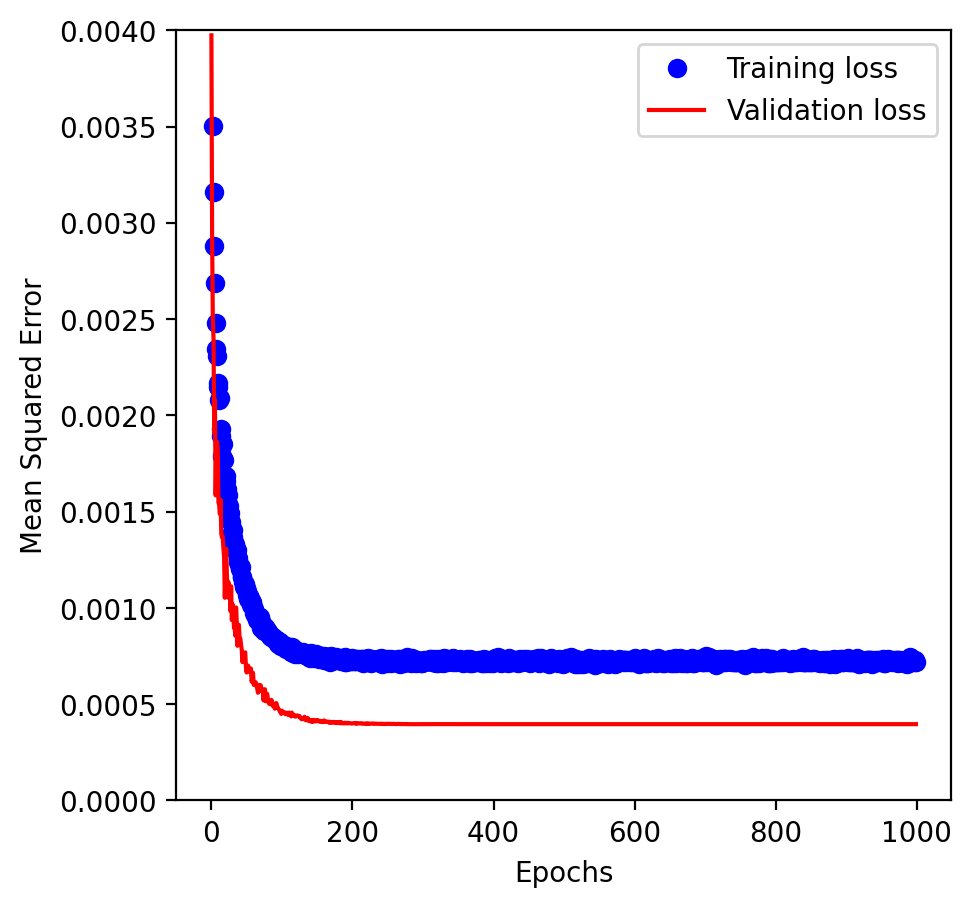

In [8]:
plot_epochs(history_final)

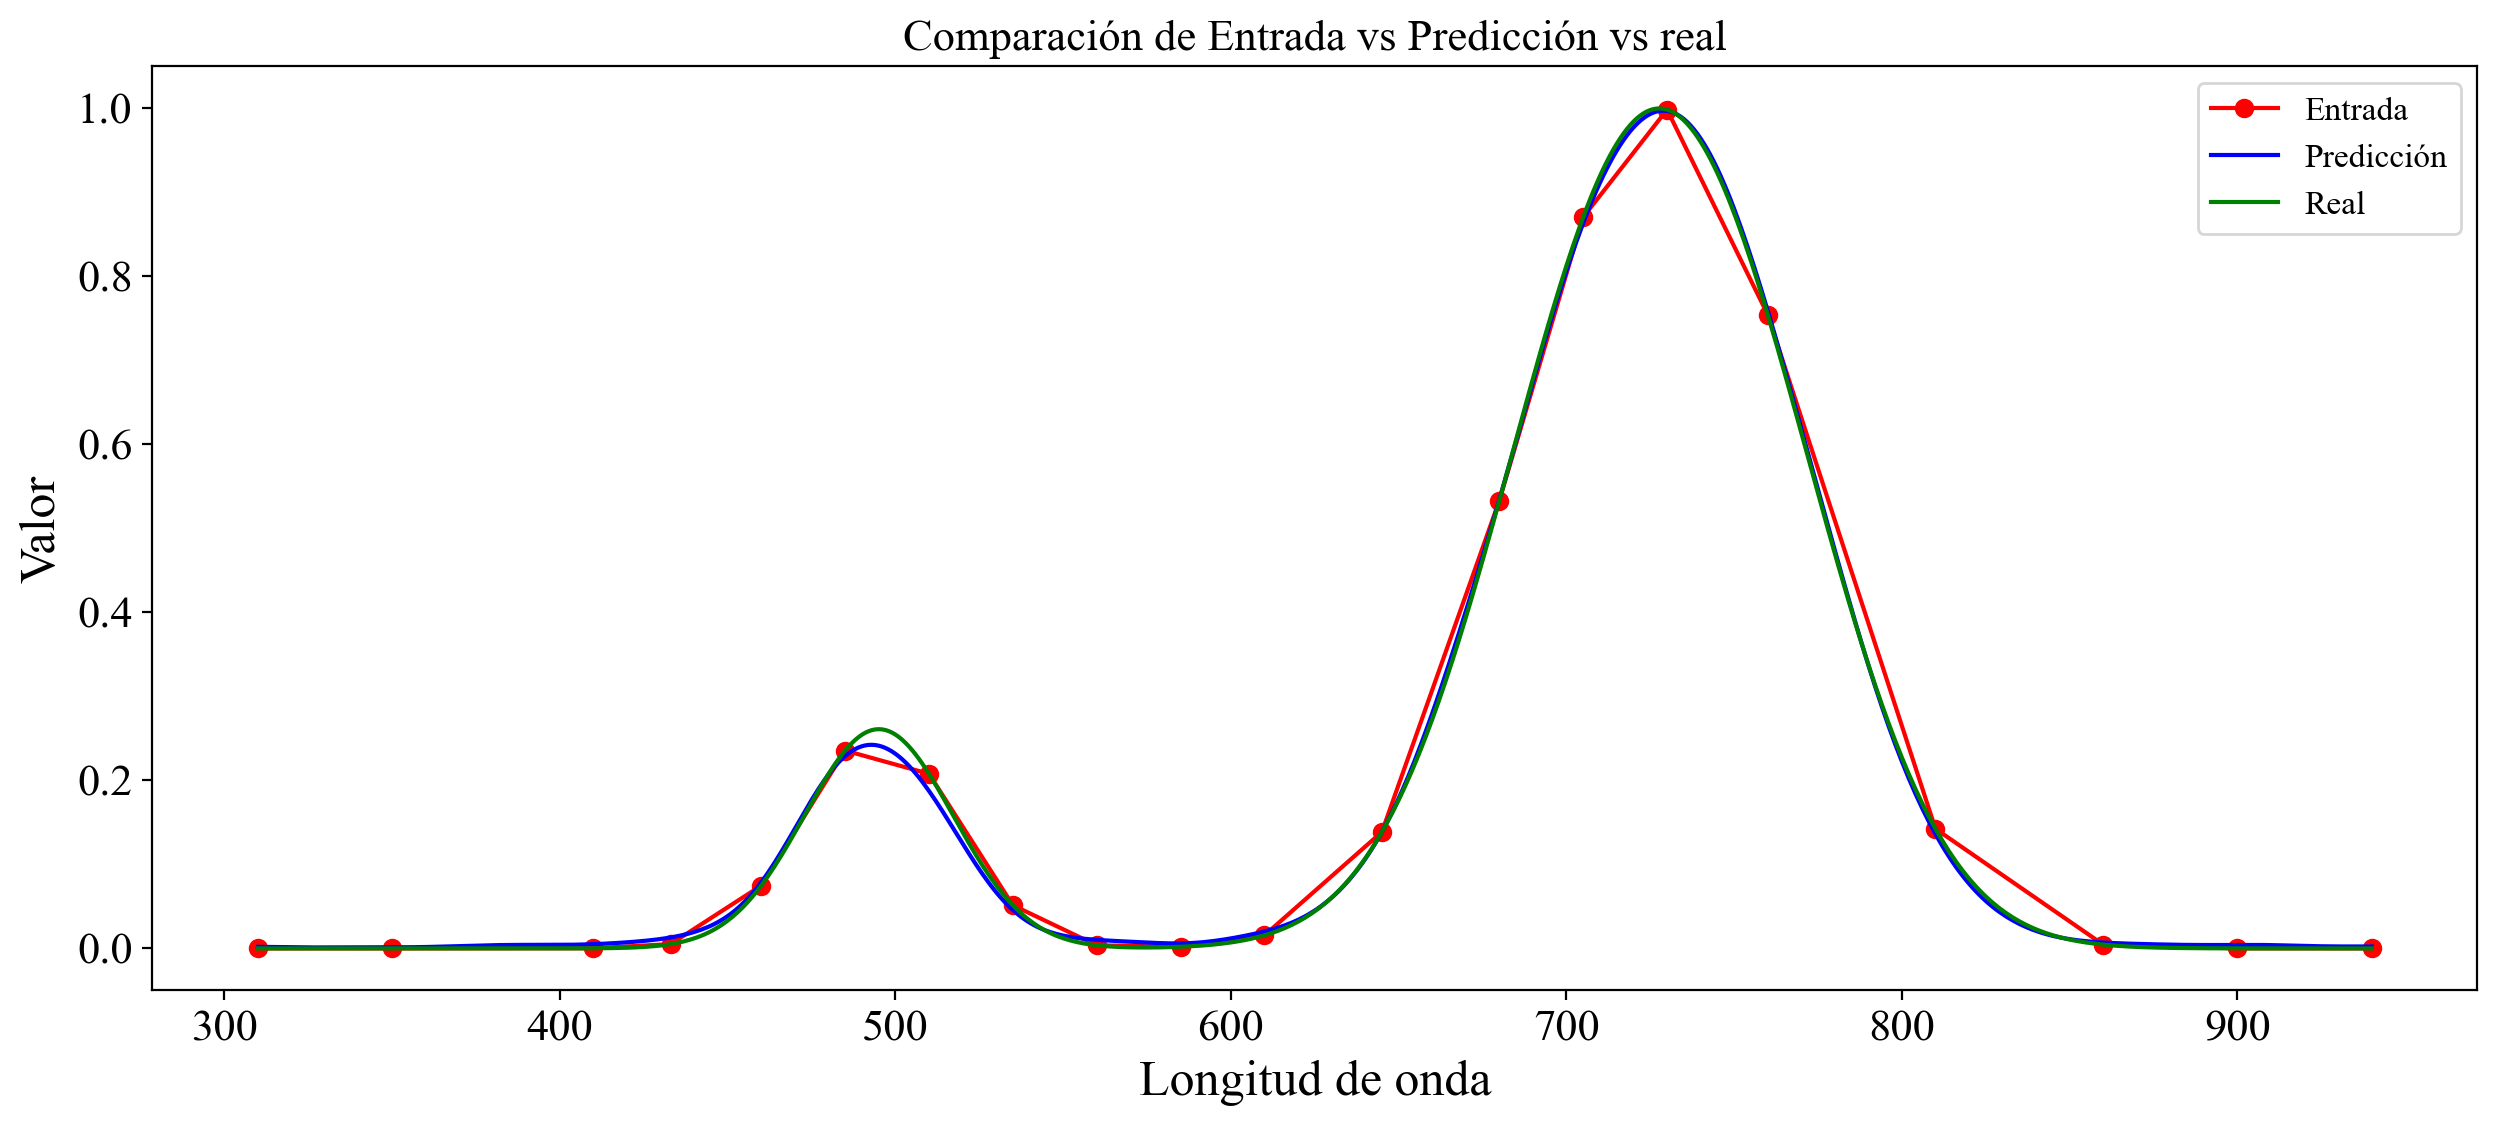

In [74]:
# Realizar predicciones

dato = 128
predictions = model.predict(X_val)
entrada = X_val[dato]
real = y_val[dato,:]

# Crear una gráfica para comparar los valores reales con las predicciones
plt.figure(figsize=(15, 6))
plt.plot(wavelengths_input, entrada, label='Entrada', color='red', marker='o')
plt.plot(wavelengths_output, predictions[dato], label='Predicción', color='blue')
plt.plot(wavelengths_output, real, label='Real', color='green')
plt.title('Comparación de Entrada vs Predicción vs real')
plt.xlabel('Longitud de onda')
plt.ylabel('Valor')
plt.legend()
plt.show()

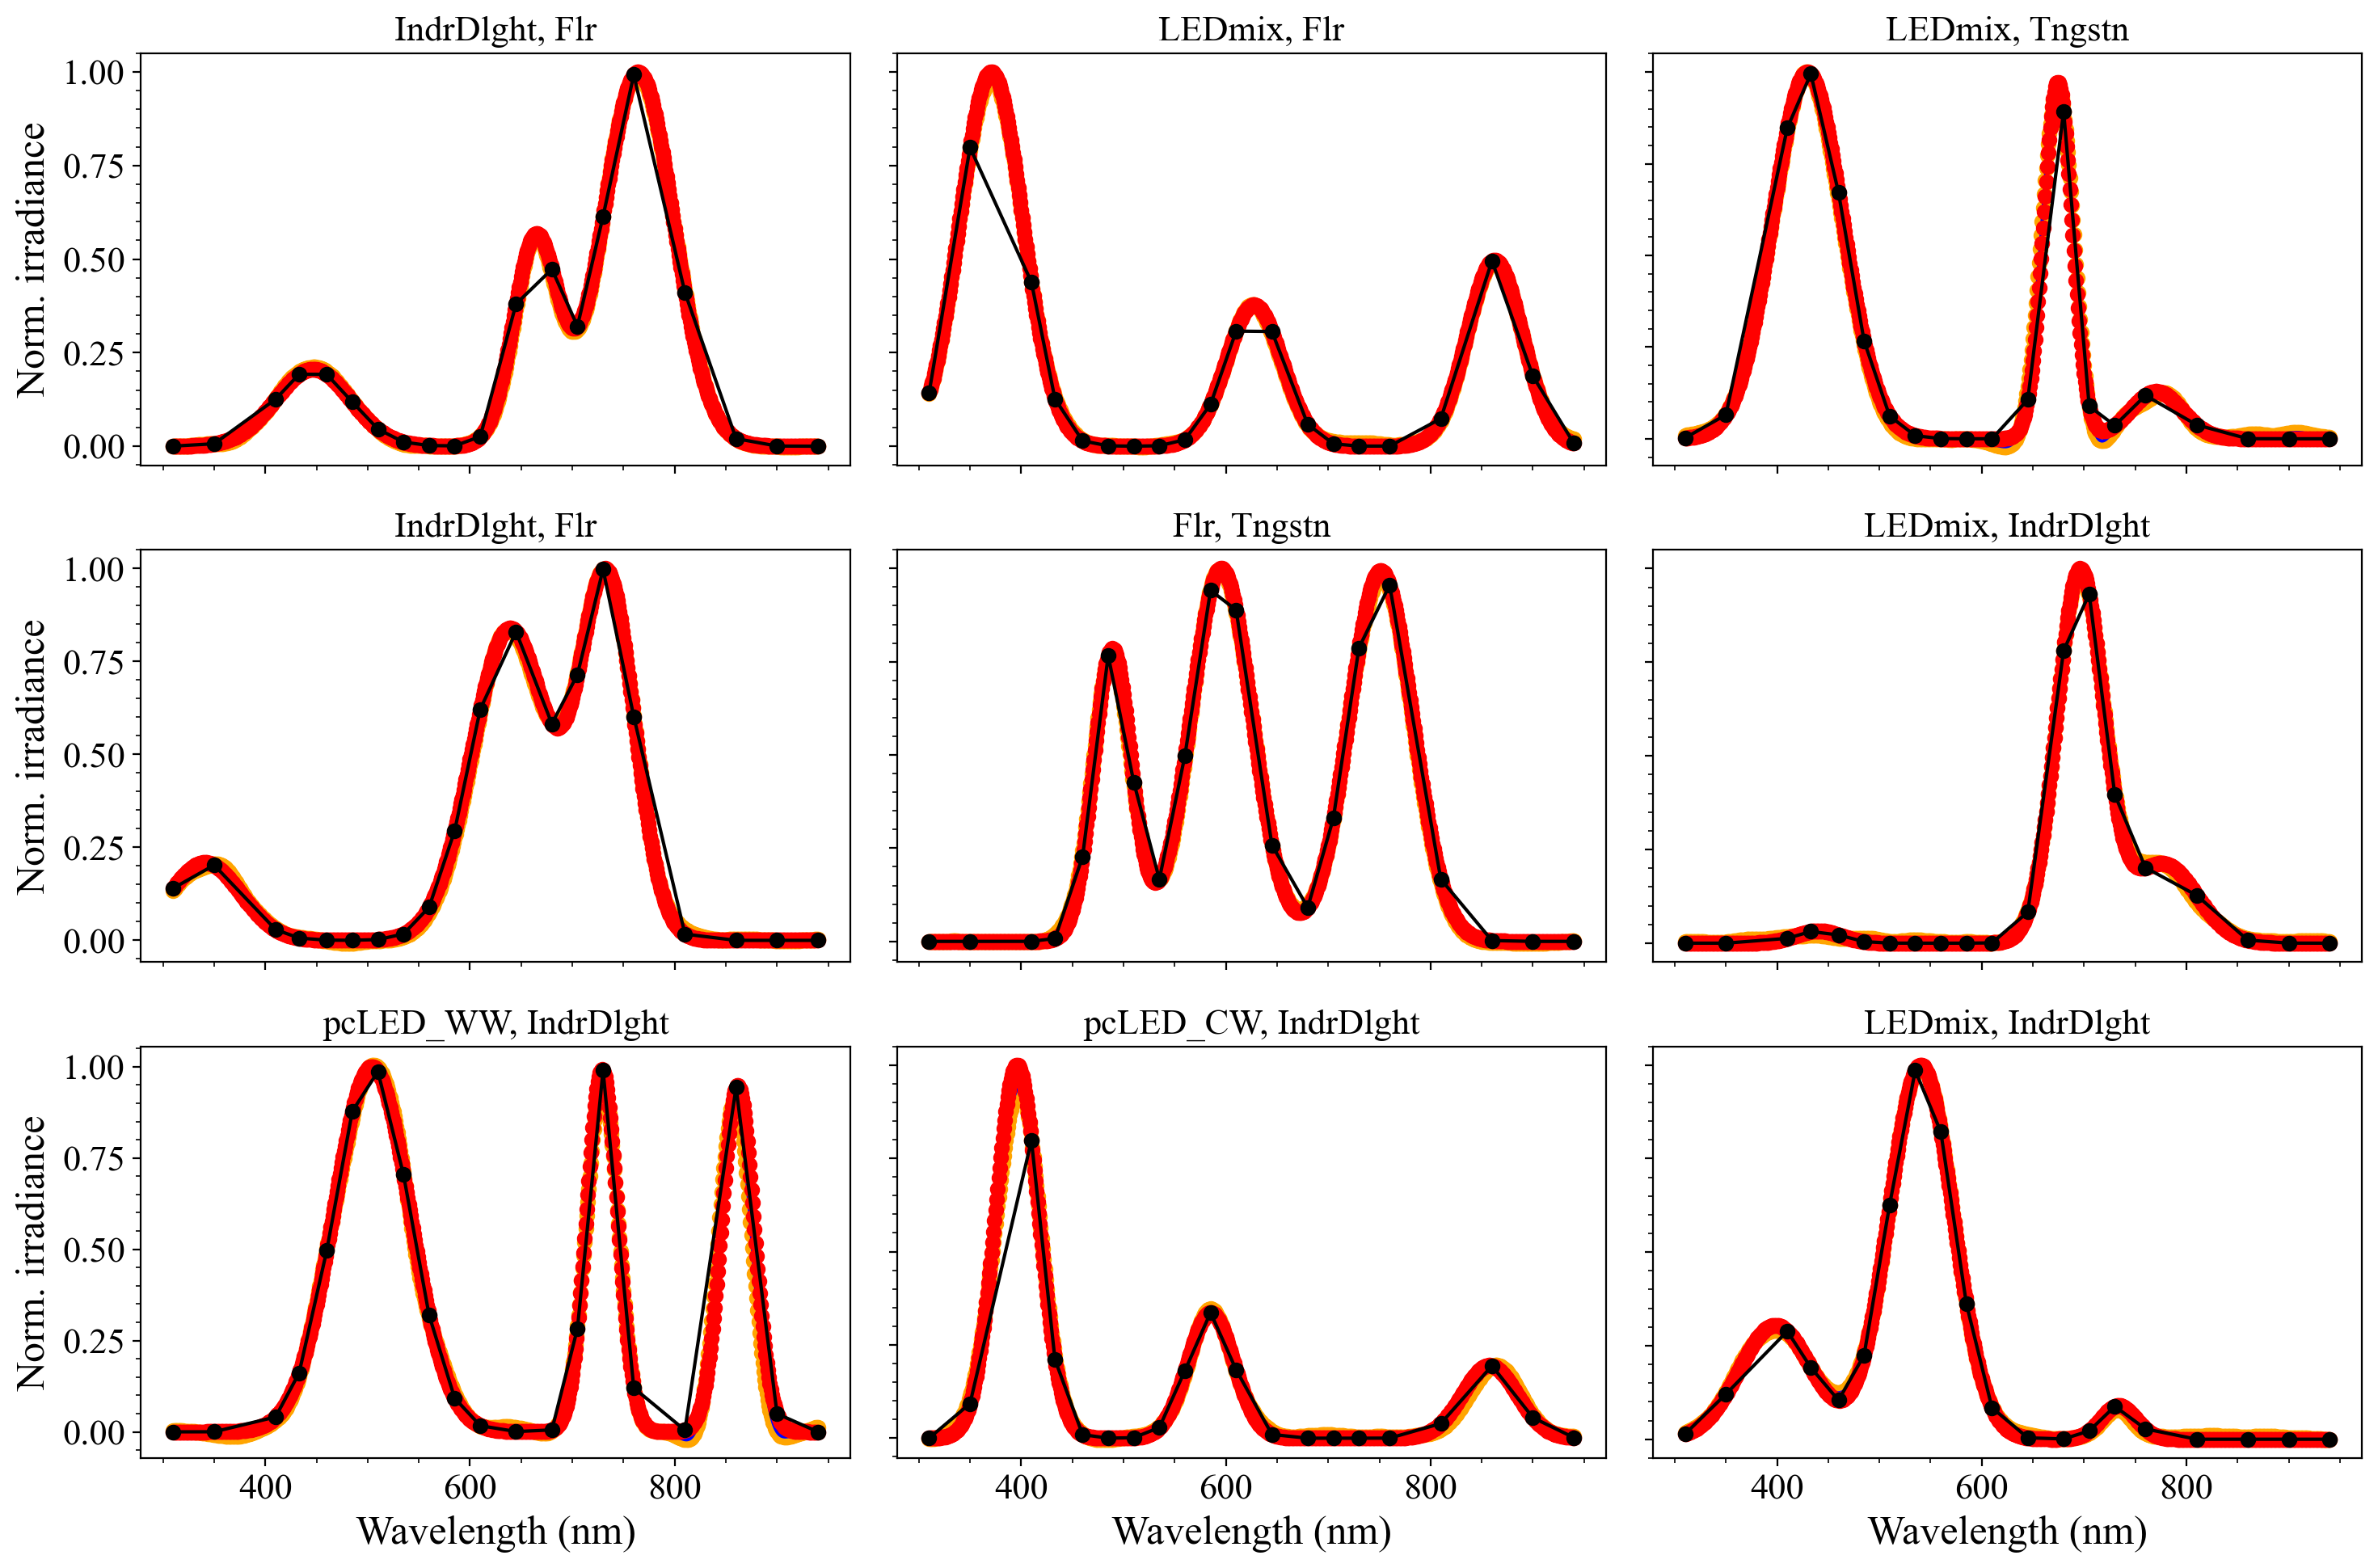

In [73]:
import matplotlib.ticker as tck
datos = np.array([12, 145, 36, 48, 50, 120, 79, 89, 181])


# Configurar la fuente a Times New Roman y el tamaño de la letra
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.titlesize"] = 20

# Configurar los subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Lista de títulos para los subplots
titles = ["IndrDlght, Flr", "LEDmix, Flr", "LEDmix, Tngstn", 
          "IndrDlght, Flr", "Flr, Tngstn", "LEDmix, IndrDlght",
          "pcLED_WW, IndrDlght", "pcLED_CW, IndrDlght", "LEDmix, IndrDlght"]

# Colores personalizados
colors = {
    'measured': 'black',
    'cnn2block': 'orange',
    'cnn1block': 'red',
    'mlp': 'blue'
}

# Iterar sobre los subplots y añadir los datos
for i, ax in enumerate(axs.flat):
    idx = datos[i]  # Obtener el índice correspondiente de 'dato'
    ax.plot(wavelengths_output, predictions[idx], color=colors['cnn2block'], marker='o', linestyle='none', label='CNN2Block')
    ax.plot(wavelengths_output, predictions[idx], color=colors['mlp'], linestyle='-', label='MLP')
    ax.plot(wavelengths_output, y_val[idx, :], color=colors['cnn1block'], marker='o', linestyle='none', label='CNN1Block')
    ax.plot(wavelengths_input, X_val[idx], marker='o', color=colors['measured'], linestyle='-', label='Measured')  
    
    # Añadir título y leyenda
    ax.set_title(titles[i])

    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

    # Añadir etiquetas solo en las posiciones deseadas
    if i // 3 == 2:  # última fila
        ax.set_xlabel('Wavelength (nm)')
    else:
        ax.set_xticklabels([])  # Eliminar etiquetas del eje X para filas que no sean la última

    if i % 3 == 0:  # primera columna
        ax.set_ylabel('Norm. irradiance')
    else:
        ax.set_yticklabels([])  # Eliminar etiquetas del eje Y para columnas que no sean la primera

# Ajustar el layout
plt.tight_layout()
plt.show()